In [32]:

import numpy as np


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [33]:
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [34]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.math.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [35]:
test_path= './test'

In [36]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range= 0.2,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                  validation_split=0.1)



#Read our images to the data augmentations
#Generates batches of augmented data
train = train_datagen.flow_from_directory(test_path,
                                          color_mode = 'rgb',
                                          target_size = (48, 48),
                                          batch_size = 64,
                                          shuffle=True,
                                          subset = 'training',
                                          class_mode = 'categorical')


test = train_datagen.flow_from_directory(test_path,
                                          color_mode = 'rgb',
                                          target_size = (48, 48),
                                          batch_size = 64,
                                          shuffle=True,
                                          subset = 'validation',
                                          class_mode = 'categorical')

Found 32302 images belonging to 7 classes.
Found 3585 images belonging to 7 classes.


In [37]:
base_model = tf.keras.applications.resnet.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [38]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))#
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))#
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))#
model.add(Dense(512,kernel_initializer='he_uniform'))#
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))#
model.add(Dense(128,kernel_initializer='he_uniform'))#
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_12 (Dropout)        (None, 2, 2, 2048)        0         
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_16 (Bat  (None, 8192)             32768     
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 1024)              8389632   
                                                                 
 batch_normalization_17 (Bat  (None, 1024)             4096      
 chNormalization)                                     

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(train.classes), 
                                                  y=train.classes)
class_weights = dict(zip(np.unique(train.classes),class_weights))

filepath = 'saved_model/my_model_resnet' #saves our best model to this location with custom name
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_delta=0.0001, verbose=1),
             tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='max'),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1,restore_best_weights=True)]


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),#0.0000005 0.003 0.00007
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
history = model.fit(train,epochs=50,validation_data=test,verbose=1,callbacks=callbacks)

Epoch 1/50
505/505 [==============================] - ETA: 0s - loss: 1.6194 - accuracy: 0.3743
Epoch 1: val_accuracy improved from -inf to 0.17099, saving model to saved_model\my_model_resnet
INFO:tensorflow:Assets written to: saved_model\my_model_resnet\assets
505/505 [==============================] - 676s 1s/step - loss: 1.6194 - accuracy: 0.3743 - val_loss: 1.9629 - val_accuracy: 0.1710 - lr: 5.0000e-04
Epoch 2/50
505/505 [==============================] - ETA: 0s - loss: 1.2898 - accuracy: 0.5140
Epoch 2: val_accuracy improved from 0.17099 to 0.49707, saving model to saved_model\my_model_resnet
INFO:tensorflow:Assets written to: saved_model\my_model_resnet\assets
505/505 [==============================] - 681s 1s/step - loss: 1.2898 - accuracy: 0.5140 - val_loss: 1.3246 - val_accuracy: 0.4971 - lr: 5.0000e-04
Epoch 3/50
505/505 [==============================] - ETA: 0s - loss: 1.1969 - accuracy: 0.5554
Epoch 3: val_accuracy improved from 0.49707 to 0.54393, saving model to saved

Epoch 23/50
505/505 [==============================] - ETA: 0s - loss: 0.5897 - accuracy: 0.7926
Epoch 23: val_accuracy did not improve from 0.65718
505/505 [==============================] - 972s 2s/step - loss: 0.5897 - accuracy: 0.7926 - val_loss: 0.9970 - val_accuracy: 0.6519 - lr: 1.6000e-07
Epoch 24/50
505/505 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.7917
Epoch 24: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-08.

Epoch 24: val_accuracy did not improve from 0.65718
505/505 [==============================] - 970s 2s/step - loss: 0.5919 - accuracy: 0.7917 - val_loss: 0.9986 - val_accuracy: 0.6508 - lr: 1.6000e-07
Epoch 25/50
505/505 [==============================] - ETA: 0s - loss: 0.5932 - accuracy: 0.7901
Epoch 25: val_accuracy did not improve from 0.65718
505/505 [==============================] - 980s 2s/step - loss: 0.5932 - accuracy: 0.7901 - val_loss: 0.9875 - val_accuracy: 0.6527 - lr: 3.2000e-08
Epoch 26/50
505/505 [=======

Epoch 48/50
505/505 [==============================] - ETA: 0s - loss: 0.5910 - accuracy: 0.7929
Epoch 48: ReduceLROnPlateau reducing learning rate to 8.192000680237733e-14.

Epoch 48: val_accuracy improved from 0.66025 to 0.66192, saving model to saved_model\my_model_resnet
INFO:tensorflow:Assets written to: saved_model\my_model_resnet\assets
505/505 [==============================] - 784s 2s/step - loss: 0.5910 - accuracy: 0.7929 - val_loss: 0.9901 - val_accuracy: 0.6619 - lr: 4.0960e-13
Epoch 49/50
505/505 [==============================] - ETA: 0s - loss: 0.5899 - accuracy: 0.7918
Epoch 49: val_accuracy did not improve from 0.66192
505/505 [==============================] - 861s 2s/step - loss: 0.5899 - accuracy: 0.7918 - val_loss: 1.0098 - val_accuracy: 0.6533 - lr: 8.1920e-14
Epoch 50/50
505/505 [==============================] - ETA: 0s - loss: 0.5893 - accuracy: 0.7921
Epoch 50: val_accuracy did not improve from 0.66192
505/505 [==============================] - 865s 2s/step - 

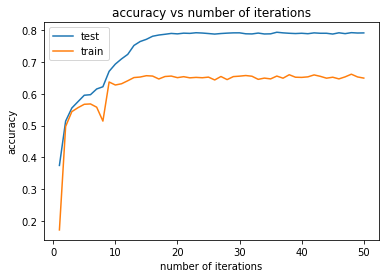

In [42]:
test_accuracy = history.history["val_accuracy"]
train_accuracy = history.history["accuracy"]

fig, ax = plt.subplots()
ax.set_xlabel('number of iterations')
ax.set_ylabel('accuracy')
ax.set_title('accuracy vs number of iterations')
ax.plot(range(1,len(train_accuracy)+1), train_accuracy,  label="test")
ax.plot(range(1,len(train_accuracy)+1), test_accuracy,  label="train")
ax.legend()
plt.show()